# Fast GRF Graph Kernel with Train/Val/Test

Clean implementation of Fast Graph Random Features kernel with proper evaluation framework.

**New Features:**
- Optional downsampling for faster computation (configurable via USE_DOWNSAMPLING and DOWNSAMPLE_FACTOR)
- Self-contained: no external .npz file dependencies - computes data fresh from NetCDF
- Automatic cache management for different grid resolutions
- Proper Aeolus track snapping that works with both full and downsampled grids

### Preprocessing

In [1]:

%reload_ext autoreload
%autoreload 2
import torch
import gpytorch
from gpytorch import settings as gsettings

from linear_operator import settings
from linear_operator.utils import linear_cg
from linear_operator.operators import IdentityLinearOperator
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import sys
sys.path.append('../..')
from efficient_graph_gp_sparse.gptorch_kernels_sparse.sparse_grf_kernel import SparseGRFKernel
from efficient_graph_gp_sparse.preprocessor import GraphPreprocessor
from graph_bo.data.database import GraphDataLoader

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
output_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Output device: {output_device}")

def to_device(data, device):
    """Helper function to move data to device"""
    if isinstance(data, dict):
        return {k: to_device(v, device) for k, v in data.items()}
    elif isinstance(data, (list, tuple)):
        return [to_device(item, device) for item in data]
    elif isinstance(data, torch.Tensor):
        return data.to(device)
    else:
        return data

Output device: cuda:0


In [2]:

# =============================================================================
# EXPERIMENT CONFIGURATION
# =============================================================================

settings.verbose_linalg._default = False
settings._fast_covar_root_decomposition._default = False

# GPyTorch settings
gsettings.max_cholesky_size._global_value = 0
gsettings.cg_tolerance._global_value = 1e-2
gsettings.max_lanczos_quadrature_iterations._global_value = 1 # Small iterations so inaccurate loss estimation
settings.fast_computations.log_prob._state = True
gsettings.num_trace_samples._global_value = 64
gsettings.min_preconditioning_size._global_value = 1e10
# gpytorch.settings.max_eager_kernel_size = 0

# Data downsampling parameters
DOWNSAMPLE_FACTOR = 20      # Downsample by factor of 10 in both lat/lon directions
USE_DOWNSAMPLING = True     # Set to False to use full resolution

# Kernel parameters
WALKS_PER_NODE = 4096      # Number of random walks per node
P_HALT = 0.05               # Halt probability for random walks
MAX_WALK_LENGTH = 10        # Maximum walk length
RANDOM_WALK_SEED = 42      # Seed for random walk generation

# Step matrices cache settings
LOAD_FROM_DISK = False    # Whether to load precomputed step matrices
SAVE_TO_DISK = False        # Whether to save computed step matrices

# Training parameters
LEARNING_RATE = 0.01        # Adam optimizer learning rate
MAX_ITERATIONS = 1000       # Maximum training iterations
PATIENCE = 20              # Early stopping patience
PRINT_INTERVAL = 30        # Progress printing interval

# Inference parameters
PATHWISE_SAMPLES = 200      # Number of samples for pathwise inference

### Load the wind speed data

In [3]:
from netCDF4 import Dataset
nc_file = '../data/raw_data/wind_interpolation/8176c14c59fd8dc32a74a89b926cb7fd.nc'
dataset = Dataset(nc_file, mode="r")
print("Variables:", dataset.variables.keys())

Variables: dict_keys(['number', 'valid_time', 'pressure_level', 'latitude', 'longitude', 'expver', 'u', 'v'])


In [4]:
# Load coordinate arrays
lat = dataset.variables["latitude"][:]      # shape (721,)
lon = dataset.variables["longitude"][:]     # shape (1440,)

# Load wind components (eastward and northward)
# Dimensions: (valid_time=12, pressure_level=3, latitude=721, longitude=1440)
u = dataset.variables["u"][:]   # eastward wind
v = dataset.variables["v"][:]   # northward wind

In [5]:
# create a long-lat gird, with values being the u, v wind components
import numpy as np
lon_grid, lat_grid = np.meshgrid(lon, lat)
u_500 = u[0, 0, :, :]  # shape (721, 1440)
v_500 = v[0, 0, :, :]  # shape (721, 1440)

# =============================================================================
# OPTIONAL DOWNSAMPLING FOR FASTER COMPUTATION
# =============================================================================

def downsample_grid_data(lat, lon, u_data, v_data, factor=10):
    """
    Downsample the lat/lon grid and corresponding data by a given factor
    
    Parameters:
    -----------
    lat : array
        Latitude coordinates
    lon : array  
        Longitude coordinates
    u_data : array
        U wind component data (lat, lon)
    v_data : array
        V wind component data (lat, lon)
    factor : int
        Downsampling factor
        
    Returns:
    --------
    lat_down, lon_down, u_down, v_down : downsampled arrays
    """
    # Downsample coordinates
    lat_down = lat[::factor]
    lon_down = lon[::factor]
    
    # Downsample data using the same indices
    u_down = u_data[::factor, ::factor]
    v_down = v_data[::factor, ::factor]
    
    print(f"Original grid: {lat.shape} x {lon.shape} = {len(lat) * len(lon):,} points")
    print(f"Downsampled grid: {lat_down.shape} x {lon_down.shape} = {len(lat_down) * len(lon_down):,} points")
    print(f"Reduction factor: {(len(lat) * len(lon)) / (len(lat_down) * len(lon_down)):.1f}x smaller")
    
    return lat_down, lon_down, u_down, v_down

# Apply downsampling if enabled
if USE_DOWNSAMPLING:
    print("Applying downsampling...")
    lat_processed, lon_processed, u_500_processed, v_500_processed = downsample_grid_data(
        lat, lon, u_500, v_500, factor=DOWNSAMPLE_FACTOR
    )
else:
    print("Using full resolution...")
    lat_processed, lon_processed, u_500_processed, v_500_processed = lat, lon, u_500, v_500
    print(f"Full grid: {lat.shape} x {lon.shape} = {len(lat) * len(lon):,} points")

Applying downsampling...
Original grid: (721,) x (1440,) = 1,038,240 points
Downsampled grid: (37,) x (72,) = 2,664 points
Reduction factor: 389.7x smaller


In [6]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from skyfield.api import load, EarthSatellite, wgs84, utc

# ----------------------------
# Step 1: Define Aeolus TLE (example from repo)
# ----------------------------
line1 = "1 43600U 18066A   21153.73585495  .00031128  00000-0  12124-3 0  9990"
line2 = "2 43600  96.7150 160.8035 0006915  90.4181 269.7884 15.87015039160910"

ts = load.timescale()
aeolus = EarthSatellite(line1, line2, "AEOLUS", ts)

# ----------------------------
# Step 2: Generate times (every minute for 24h starting Jan 1, 2019 09:00 UTC)
# ----------------------------
start = datetime(2019, 1, 1, 9, tzinfo=utc)
stop = start + timedelta(hours=24)
step = timedelta(minutes=1)

times = []
t = start
while t <= stop:
    times.append(t)
    t += step

# ----------------------------
# Step 3: Propagate orbit to get lat/lon
# ----------------------------
geocentric = aeolus.at(ts.from_datetimes(times))
lat, lon = wgs84.latlon_of(geocentric)

# Convert to arrays in degrees
lat = lat.degrees
lon = lon.degrees % 360  # wrap to [0,360)

raw_track = pd.DataFrame({"time": times, "lat": lat, "lon": lon})

# ----------------------------
# Step 4: Snap to ERA5 grid (adjusted for downsampling)
# ----------------------------
if USE_DOWNSAMPLING:
    # Use the downsampled grid for snapping
    era5_lat = lat_processed  # Already downsampled
    era5_lon = lon_processed  # Already downsampled
    print(f"Snapping to downsampled grid: {len(era5_lat)} x {len(era5_lon)} points")
else:
    # Use original full resolution grid
    era5_lat = np.linspace(90, -90, 721)       # descending order
    era5_lon = np.linspace(0, 359.75, 1440)    # 0.25° spacing
    print(f"Snapping to full resolution grid: {len(era5_lat)} x {len(era5_lon)} points")

def snap_to_grid(lat_val, lon_val):
    i = np.abs(era5_lat - lat_val).argmin()
    j = np.abs(era5_lon - lon_val).argmin()
    return era5_lat[i], era5_lon[j]

snapped = [snap_to_grid(phi, lam) for phi, lam in zip(lat, lon)]
snap_lat, snap_lon = zip(*snapped)

snapped_track = pd.DataFrame({"time": times, "lat": snap_lat, "lon": snap_lon})

# ----------------------------
# Example outputs
# ----------------------------
print("Raw track sample:\n", raw_track.head())
print("Snapped track sample:\n", snapped_track.head())

Snapping to downsampled grid: 37 x 72 points
Raw track sample:
                        time        lat         lon
0 2019-01-01 09:00:00+00:00  38.799453  165.145970
1 2019-01-01 09:01:00+00:00  43.290230  163.965622
2 2019-01-01 09:02:00+00:00  47.767775  162.637952
3 2019-01-01 09:03:00+00:00  52.228839  161.108544
4 2019-01-01 09:04:00+00:00  56.668617  159.295027
Snapped track sample:
                        time   lat    lon
0 2019-01-01 09:00:00+00:00  40.0  165.0
1 2019-01-01 09:01:00+00:00  45.0  165.0
2 2019-01-01 09:02:00+00:00  50.0  165.0
3 2019-01-01 09:03:00+00:00  50.0  160.0
4 2019-01-01 09:04:00+00:00  55.0  160.0


Creating wind velocity quiver plot...
Using Cartopy for world map background


/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


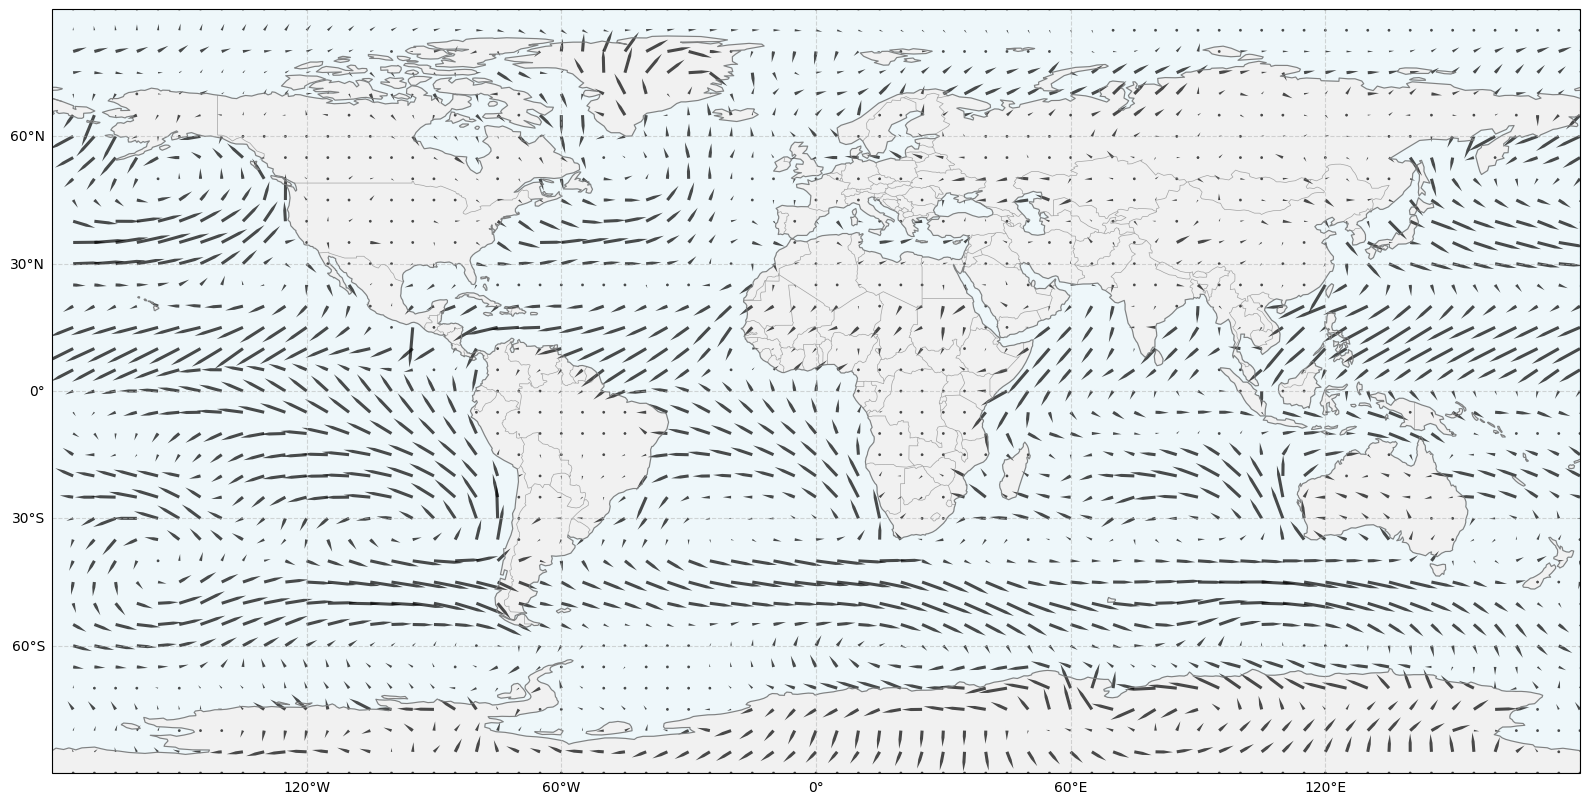

In [7]:
# =============================================================================
# QUIVER PLOT: GROUND TRUTH WIND VELOCITY VECTORS
# =============================================================================

def plot_wind_velocity_quiver(skip_factor=3, figsize=(16, 10), arrow_scale=None):
    """
    Create a quiver plot showing wind velocity vectors (u, v components) with world map background
    
    Parameters:
    -----------
    skip_factor : int
        Skip every N points in both directions to reduce arrow density
    figsize : tuple
        Figure size (width, height)
    arrow_scale : float or None
        Scale factor for arrow lengths. If None, auto-scale
    """
    
    # Try to import cartopy for world map features
    try:
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        use_cartopy = True
        print("Using Cartopy for world map background")
    except ImportError:
        use_cartopy = False
        print("Cartopy not available, using basic plot without map background")
    
    # Create coordinate grids for the processed data
    lon_2d, lat_2d = np.meshgrid(lon_processed, lat_processed)
    
    # Apply skip factor to reduce arrow density
    lon_skip = lon_2d[::skip_factor, ::skip_factor]
    lat_skip = lat_2d[::skip_factor, ::skip_factor]
    u_skip = u_500_processed[::skip_factor, ::skip_factor]
    v_skip = v_500_processed[::skip_factor, ::skip_factor]
    
    if use_cartopy:
        # Create figure with cartopy projection
        fig = plt.figure(figsize=figsize)
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        # Add map features
        ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='gray')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, color='gray', alpha=0.7)
        ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.3)
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)
        
        # Create quiver plot (no color, just black arrows)
        quiver = ax.quiver(
            lon_skip, lat_skip, u_skip, v_skip,
            angles='xy',           # Interpret u,v as x,y components
            scale_units='width',   # Scale arrows relative to plot width
            scale=500,              # Much larger arrows (very small scale value)
            width=0.002,          # Much thicker arrow shaft width
            headwidth=1,          # Larger arrow head width
            headlength=3,         # Longer arrow head length
            color='black',        # No coloring, just black arrows
            alpha=0.7,            # Full opacity
            transform=ccrs.PlateCarree()
        )
        
        # Set extent to match data
        ax.set_extent([lon_processed.min(), lon_processed.max(), 
                      lat_processed.min(), lat_processed.max()], 
                     crs=ccrs.PlateCarree())
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False,
                         alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        
    else:
        # Fallback to regular matplotlib plot
        plt.figure(figsize=figsize)
        ax = plt.gca()
        
        # Create quiver plot (no color, just black arrows)
        quiver = plt.quiver(
            lon_skip, lat_skip, u_skip, v_skip,
            angles='xy',           # Interpret u,v as x,y components
            scale_units='width',   # Scale arrows relative to plot width
            scale=500,              # Much larger arrows (very small scale value)
            width=0.002,          # Much thicker arrow shaft width
            headwidth=1,          # Larger arrow head width
            headlength=5,         # Longer arrow head length
            color='black',        # No coloring, just black arrows
            alpha=0.7             # Full opacity
        )
        
        # Set axis limits to match the data extent
        plt.xlim(lon_processed.min(), lon_processed.max())
        plt.ylim(lat_processed.min(), lat_processed.max())
        
        # Add grid for reference
        plt.grid(True, alpha=0.3, linestyle='--')
        
        plt.xlabel('Longitude (°)', fontsize=12)
        plt.ylabel('Latitude (°)', fontsize=12)
    
    # No title, legend, or statistics text - clean visualization
    
    plt.tight_layout()
    plt.show()

# Create the quiver plot
print("Creating wind velocity quiver plot...")
plot_wind_velocity_quiver(skip_factor=1, figsize=(16, 10))

In [8]:
# =============================================================================
# EARTH PROJECTION QUIVER PLOT: Wind Vectors on Spherical Earth
# =============================================================================

def plot_wind_velocity_earth_projection(skip_factor=3, figsize=(16, 10), projection='Robinson'):
    """
    Create a quiver plot showing wind velocity vectors on a spherical Earth projection
    
    Parameters:
    -----------
    skip_factor : int
        Skip every N points in both directions to reduce arrow density
    figsize : tuple
        Figure size (width, height)
    projection : str
        Map projection ('Robinson', 'Mollweide', 'PlateCarree', 'Orthographic')
    """
    
    # Try to import cartopy for Earth projections
    try:
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        use_cartopy = True
        print(f"Using Cartopy with {projection} projection for spherical Earth visualization")
    except ImportError:
        use_cartopy = False
        print("Cartopy not available, cannot create Earth projection")
        return
    
    # Create coordinate grids and handle longitude wrapping
    # Extend data by wrapping the first longitude column to the end to eliminate discontinuity
    lon_extended = np.append(lon_processed, lon_processed[0] + 360)
    u_extended = np.concatenate([u_500_processed, u_500_processed[:, 0:1]], axis=1)
    v_extended = np.concatenate([v_500_processed, v_500_processed[:, 0:1]], axis=1)
    
    # Create extended coordinate grids
    lon_2d_ext, lat_2d_ext = np.meshgrid(lon_extended, lat_processed)
    
    # Apply skip factor to reduce arrow density
    lon_skip = lon_2d_ext[::skip_factor, ::skip_factor]
    lat_skip = lat_2d_ext[::skip_factor, ::skip_factor]
    u_skip = u_extended[::skip_factor, ::skip_factor]
    v_skip = v_extended[::skip_factor, ::skip_factor]
    
    # Select projection
    if projection == 'Robinson':
        proj = ccrs.Robinson(central_longitude=0)
    elif projection == 'Mollweide':
        proj = ccrs.Mollweide(central_longitude=0)
    elif projection == 'Orthographic':
        proj = ccrs.Orthographic(central_longitude=0, central_latitude=30)
    else:
        proj = ccrs.PlateCarree()
    
    # Create figure with Earth projection
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=proj)
    
    # Add Earth features with more prominent styling for spherical view
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0, color='darkgray', alpha=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, color='gray', alpha=0.6)
    ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.4)
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
    
    # No background wind speed coloring - clean black arrows only
    
    # Create quiver plot for wind direction vectors - black arrows only
    quiver = ax.quiver(
        lon_skip, lat_skip, u_skip, v_skip,
        angles='xy',           # Interpret u,v as x,y components
        scale_units='width',   # Scale arrows relative to plot width
        scale=500,             # Adjusted scale for Earth projection
        width=0.002,          # Arrow shaft width
        headwidth=0.6,          # Arrow head width  
        headlength=4,         # Arrow head length
        color='black',        # Black arrows only
        alpha=0.6,            # High opacity for visibility
        transform=ccrs.PlateCarree()  # Data is in lat/lon coordinates
    )
    
    # Add red dots for training locations (Aeolus satellite track)
    train_coords = data['coord_mapping'][data['X_train'].flatten().int().cpu().numpy()]
    train_lats = train_coords[:, 0]
    train_lons = train_coords[:, 1]
    
    # Plot training locations as small red dots
    ax.scatter(
        train_lons, train_lats,
        c='red',
        s=5,                  # Small dot size
        alpha=0.8,
        edgecolors='darkred',
        linewidth=0.2,
        transform=ccrs.PlateCarree(),
        zorder=10             # Put dots on top of arrows
    )
    
    # Set global extent
    ax.set_global()
    
    # Add gridlines for reference
    if projection in ['Robinson', 'Mollweide']:
        gl = ax.gridlines(
            draw_labels=False,  # Labels don't work well with these projections
            alpha=0.3, 
            linestyle='--',
            color='gray'
        )
    else:
        gl = ax.gridlines(
            draw_labels=True, 
            dms=False, 
            x_inline=False, 
            y_inline=False,
            alpha=0.3, 
            linestyle='--',
            color='gray'
        )
        gl.top_labels = False
        gl.right_labels = False
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Earth projection plot created:")
    print(f"  Projection: {projection}")
    print(f"  Wind vectors: {lon_skip.size:,} arrows")
    print(f"  Training locations: {len(train_lats):,} red dots")
    print(f"  Coverage: Global")
    print(f"  Style: Black arrows + red training dots")

# Note: Earth projection plot will be created after data preparation

In [9]:
import numpy as np
import networkx as nx
from scipy import sparse

# ----------------------------
# Utilities
# ----------------------------
def deg2rad(x):
    return np.deg2rad(x)

def sph2cart(lat_deg, lon_deg, r=1.0):
    """
    Convert geographic coords (degrees) to 3D unit-sphere (x,y,z).
    lat: [-90, +90], lon: [0, 360) or [-180,180)
    """
    lat = deg2rad(lat_deg)
    lon = deg2rad(lon_deg)
    x = r * np.cos(lat) * np.cos(lon)
    y = r * np.cos(lat) * np.sin(lon)
    z = r * np.sin(lat)
    return np.stack([x, y, z], axis=-1)

def great_circle_distance(lat1_deg, lon1_deg, lat2_deg, lon2_deg, R=1.0):
    """
    Great-circle distance using the haversine formula (on sphere radius R).
    Returns distance on the sphere surface (arc length).
    """
    lat1, lon1 = deg2rad(lat1_deg), deg2rad(lon1_deg)
    lat2, lon2 = deg2rad(lat2_deg), deg2rad(lon2_deg)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
    return R * c

def grid_index(i, j, n_lat, n_lon):
    """Flatten (i,j) -> node id."""
    return i * n_lon + j

def inverse_grid_index(node_id, n_lat, n_lon):
    """Unflatten node id -> (i,j)."""
    i = node_id // n_lon
    j = node_id % n_lon
    return i, j

# ----------------------------
# Graph builder
# ----------------------------
def build_sphere_grid_graph(lat, lon, connectivity=4, weight="geodesic", radius=1.0):
    """
    Build a mesh-graph over a regular lat-lon grid on the sphere.

    Parameters
    ----------
    lat : (N_lat,) array (e.g., 721 from +90 to -90)
    lon : (N_lon,) array (e.g., 1440 from 0 to 359.75)
    connectivity : 4 or 8
        4-neighbour: north/south/east/west with periodic wrap in longitude
        8-neighbour: also connect diagonals
    weight : "geodesic" or None
        If "geodesic", weights are great-circle distances (arc length on sphere radius).
        If None, use unweighted edges.
    radius : float
        Sphere radius; 1.0 for unit sphere.

    Returns
    -------
    G : networkx.Graph
        Nodes [0..N_lat*N_lon-1] with attributes:
          - lat, lon (degrees)
          - xyz: (x,y,z) on unit sphere
    A : scipy.sparse.csr_matrix
        Weighted adjacency (symmetric).
    """
    n_lat = len(lat)
    n_lon = len(lon)

    # Precompute per-node attributes
    Lon_grid, Lat_grid = np.meshgrid(lon, lat)  # shapes (n_lat, n_lon)
    xyz = sph2cart(Lat_grid.ravel(), Lon_grid.ravel(), r=1.0)

    # Build edges
    rows = []
    cols = []
    data = []

    # neighbor offsets (diagonals optional)
    nbrs_4 = [(0, 1), (0, -1), (1, 0), (-1, 0)]          # E, W, S, N (i is lat index; note lat usually descending)
    nbrs_8 = nbrs_4 + [(1, 1), (1, -1), (-1, 1), (-1, -1)]
    nbrs = nbrs_8 if connectivity == 8 else nbrs_4

    for i in range(n_lat):
        for j in range(n_lon):
            nid = grid_index(i, j, n_lat, n_lon)
            for di, dj in nbrs:
                ii = i + di
                jj = (j + dj) % n_lon  # periodic in longitude
                if 0 <= ii < n_lat:
                    nid2 = grid_index(ii, jj, n_lat, n_lon)

                    if weight == "geodesic":
                        w = great_circle_distance(lat[i], lon[j], lat[ii], lon[jj], R=radius)
                    else:
                        w = 1.0

                    rows.append(nid)
                    cols.append(nid2)
                    data.append(w)

    # Symmetric adjacency
    A = sparse.coo_matrix((data, (rows, cols)), shape=(n_lat*n_lon, n_lat*n_lon))
    # Make explicitly symmetric (since we added both directions for E/W etc., this is safe)
    A = ((A + A.T) * 0.5).tocsr()

    # Build networkx graph from adjacency
    G = nx.from_scipy_sparse_array(A)
    # Attach node attributes
    node_attrs = {}
    for nid in range(n_lat * n_lon):
        i, j = inverse_grid_index(nid, n_lat, n_lon)
        node_attrs[nid] = {
            "lat": float(lat[i]),
            "lon": float(lon[j]),
            "xyz": tuple(xyz[nid]),
        }
    nx.set_node_attributes(G, node_attrs)

    return G, A

# ----------------------------
# Snapping helpers
# ----------------------------
def nearest_node_indices_for_track(track_lat, track_lon, lat, lon):
    """
    Given a track of points (lat, lon), return nearest grid (i,j) for each.
    Works for ERA5-style regular grid.

    Returns
    -------
    idx_ij : array of shape (N, 2) with int (i, j) indices.
    node_ids : array of shape (N,) flattened node ids.
    """
    # ERA5 latitude is often descending (90 -> -90); lon is uniform [0, 360)
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    track_lat = np.asarray(track_lat)
    track_lon = np.asarray(track_lon) % 360.0

    # nearest indices by absolute difference (fast for regular grid)
    i_idx = np.abs(track_lat[:, None] - lat[None, :]).argmin(axis=1)
    # Note: if your lon is [-180,180), normalize both to same frame first.
    j_idx = np.abs(track_lon[:, None] - lon[None, :]).argmin(axis=1)

    node_ids = i_idx * len(lon) + j_idx
    idx_ij = np.stack([i_idx, j_idx], axis=1)
    return idx_ij, node_ids


In [10]:
# Build graph using processed (potentially downsampled) coordinates
lat_for_graph = lat_processed
lon_for_graph = lon_processed
G, A = build_sphere_grid_graph(lat_for_graph, lon_for_graph, connectivity=4, weight="geodesic", radius=1.0)

# Snap Aeolus track to the processed (potentially downsampled) grid
idx_ij, node_ids = nearest_node_indices_for_track(
    track_lat=snapped_track["lat"].values,
    track_lon=snapped_track["lon"].values,
    lat=lat_for_graph, lon=lon_for_graph,
)

# Example: pull those nodes' 3D coordinates to plot on a sphere later
xyz_track = np.array([G.nodes[n]["xyz"] for n in node_ids])

print(f"Graph statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Adjacency matrix shape: {A.shape}")
print(f"Number of Aeolus track points: {len(node_ids)}")
print(f"Unique track nodes: {len(np.unique(node_ids))}")

Graph statistics:
Number of nodes: 2664
Number of edges: 5256
Adjacency matrix shape: (2664, 2664)
Number of Aeolus track points: 1441
Unique track nodes: 1161


In [11]:
# =============================================================================
# FINAL DATA PREPARATION FOR MACHINE LEARNING
# =============================================================================

print("Preparing final datasets for training...")

# 1. Use the processed (potentially downsampled) wind data
lat_grid = lat_processed
lon_grid = lon_processed  
u_component = u_500_processed
v_component = v_500_processed

print(f"Using {'downsampled' if USE_DOWNSAMPLING else 'full resolution'} data:")
print(f"Grid shape: lat {lat_grid.shape}, lon {lon_grid.shape}")
print(f"Wind data shape: u {u_component.shape}, v {v_component.shape}")

# 2. Create adjacency matrix A (already computed above as sparse CSR)
A = A.tocsr()  # Ensure CSR format
print(f"Adjacency matrix A shape: {A.shape}, format: {A.format}")

# 3. Create node indices (consistent with graph construction)
n_lat, n_lon = len(lat_grid), len(lon_grid)
X = np.arange(n_lat * n_lon)  # Node indices [0, 1, 2, ..., n_nodes-1]

print(f"Node indices X shape: {X.shape}")

# 4. Create wind speed targets with CONSISTENT indexing
# Ensure the flattening matches our node indexing: node_id = i * n_lon + j
y = np.zeros(n_lat * n_lon)
coord_mapping = np.zeros((n_lat * n_lon, 2))

for i in range(n_lat):
    for j in range(n_lon):
        node_id = i * n_lon + j  # Same indexing as in graph construction
        
        # Extract wind components at this grid point
        u_val = u_component[i, j]
        v_val = v_component[i, j]
        wind_speed = np.sqrt(u_val**2 + v_val**2)
        
        # Assign to correct node index
        y[node_id] = wind_speed
        
        # Store coordinate mapping for reference
        coord_mapping[node_id, 0] = lat_grid[i]  # latitude
        coord_mapping[node_id, 1] = lon_grid[j]  # longitude

print(f"Wind speed targets y shape: {y.shape}")

# 4.1. Create separate u and v component targets
y_u = np.zeros(n_lat * n_lon)  # u-component targets
y_v = np.zeros(n_lat * n_lon)  # v-component targets

for i in range(n_lat):
    for j in range(n_lon):
        node_id = i * n_lon + j
        y_u[node_id] = u_component[i, j]
        y_v[node_id] = v_component[i, j]

# 4.2. Normalize u and v components separately
y_u_mean, y_u_std = np.mean(y_u), np.std(y_u)
y_v_mean, y_v_std = np.mean(y_v), np.std(y_v)
y_u_norm = (y_u - y_u_mean) / y_u_std
y_v_norm = (y_v - y_v_mean) / y_v_std

# Also normalize wind speed magnitude for reference
y_raw = y.copy()  # Keep original for reference
y_mean = np.mean(y)
y_std = np.std(y)
y = (y - y_mean) / y_std

print(f"Component normalization:")
print(f"  U-component: mean={y_u_mean:.3f} m/s, std={y_u_std:.3f} m/s")
print(f"  V-component: mean={y_v_mean:.3f} m/s, std={y_v_std:.3f} m/s")
print(f"  Wind speed: mean={y_mean:.3f} m/s, std={y_std:.3f} m/s")

# 5. Create training locations (Aeolus satellite track node indices)
# Get unique node indices from the Aeolus track
unique_train_nodes = np.unique(node_ids)
X_train = unique_train_nodes  # Training node indices
y_train = y[X_train]  # Corresponding wind speeds at those nodes
y_u_train = y_u_norm[X_train]  # U-component training targets
y_v_train = y_v_norm[X_train]  # V-component training targets

print(f"Training node indices X_train shape: {X_train.shape}")
print(f"Training wind speeds y_train shape: {y_train.shape}")

# 6. Verify consistency
print(f"\nVerification:")
print(f"X min: {X.min()}, max: {X.max()}")
print(f"y length: {len(y)}")
print(f"X_train min: {X_train.min()}, max: {X_train.max()}")
print(f"All X_train indices within y bounds: {np.all(X_train < len(y))}")

# 7. Summary of final datasets
print("\n" + "="*60)
print("FINAL DATASET SUMMARY")
print("="*60)
print(f"A (adjacency matrix):     {A.shape} sparse CSR")
print(f"X (node indices):         {X.shape} - node indices [0, 1, ..., {len(X)-1}]")
print(f"y (wind speeds):          {y.shape} - wind speed magnitudes")
print(f"X_train (training nodes): {X_train.shape} - Aeolus track node indices")
print(f"y_train (training speeds): {y_train.shape} - Wind speeds at Aeolus locations")
print(f"coord_mapping:            {coord_mapping.shape} - (lat, lon) for each node")

# 8. Save the prepared datasets
# Also save original u,v components with consistent indexing
u_flat_consistent = np.zeros(n_lat * n_lon)
v_flat_consistent = np.zeros(n_lat * n_lon)

for i in range(n_lat):
    for j in range(n_lon):
        node_id = i * n_lon + j
        u_flat_consistent[node_id] = u_component[i, j]
        v_flat_consistent[node_id] = v_component[i, j]

np.savez('wind_data_processed_500hPa.npz',
         A_data=A.data,
         A_indices=A.indices, 
         A_indptr=A.indptr,
         A_shape=A.shape,
         X=X,
         y=y,  # Normalized wind speeds
         y_mean=y_mean,  # Normalization mean (for reference)
         y_std=y_std,   # Normalization std (for reference)
         X_train=X_train,
         y_train=y_train,
         coord_mapping=coord_mapping,
         u_component=u_flat_consistent,  # Consistently indexed u components
         v_component=v_flat_consistent)  # Consistently indexed v components

print(f"\nAll datasets saved to 'wind_data_processed_500hPa.npz'")
print("Use scipy.sparse.csr_matrix((data, indices, indptr), shape) to reconstruct A")
print("Use coord_mapping[node_idx] to get (lat, lon) coordinates for any node")
print("X and y are now consistently indexed: y[X[i]] gives wind speed for node i")

Preparing final datasets for training...
Using downsampled data:
Grid shape: lat (37,), lon (72,)
Wind data shape: u (37, 72), v (37, 72)
Adjacency matrix A shape: (2664, 2664), format: csr
Node indices X shape: (2664,)
Wind speed targets y shape: (2664,)
Component normalization:
  U-component: mean=-0.013 m/s, std=4.224 m/s
  V-component: mean=-0.152 m/s, std=2.544 m/s
  Wind speed: mean=3.993 m/s, std=2.898 m/s
Training node indices X_train shape: (1161,)
Training wind speeds y_train shape: (1161,)

Verification:
X min: 0, max: 2663
y length: 2664
X_train min: 79, max: 2586
All X_train indices within y bounds: True

FINAL DATASET SUMMARY
A (adjacency matrix):     (2664, 2664) sparse CSR
X (node indices):         (2664,) - node indices [0, 1, ..., 2663]
y (wind speeds):          (2664,) - wind speed magnitudes
X_train (training nodes): (1161,) - Aeolus track node indices
y_train (training speeds): (1161,) - Wind speeds at Aeolus locations
coord_mapping:            (2664, 2) - (lat, lo

In [12]:
data = {
    'A': A,
    'X': torch.tensor(X, dtype=torch.float32, device=output_device).unsqueeze(1),
    'y': torch.tensor(y, dtype=torch.float32, device=output_device),  # Normalized wind speed
    'y_u': torch.tensor(y_u_norm, dtype=torch.float32, device=output_device),  # Normalized u-component
    'y_v': torch.tensor(y_v_norm, dtype=torch.float32, device=output_device),  # Normalized v-component
    'X_train': torch.tensor(X_train, dtype=torch.float32, device=output_device).unsqueeze(1),
    'y_train': torch.tensor(y_train, dtype=torch.float32, device=output_device),  # Wind speed training
    'y_u_train': torch.tensor(y_u_train, dtype=torch.float32, device=output_device),  # U training
    'y_v_train': torch.tensor(y_v_train, dtype=torch.float32, device=output_device),  # V training
    'coord_mapping': coord_mapping,
    'u_component': torch.tensor(u_flat_consistent, dtype=torch.float32, device=output_device),
    'v_component': torch.tensor(v_flat_consistent, dtype=torch.float32, device=output_device),
    # Store normalization parameters
    'y_u_mean': y_u_mean, 'y_u_std': y_u_std,
    'y_v_mean': y_v_mean, 'y_v_std': y_v_std
}

print(f"Data prepared with normalization:")
print(f"  All data in normalized scale: mean=0, std=1")
print(f"  Original stats: mean={y_mean:.3f} m/s, std={y_std:.3f} m/s")

Data prepared with normalization:
  All data in normalized scale: mean=0, std=1
  Original stats: mean=3.993 m/s, std=2.898 m/s


Creating wind vectors on spherical Earth projection with training locations...
Using Cartopy with Robinson projection for spherical Earth visualization


/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/cartopy/crs.py:547: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


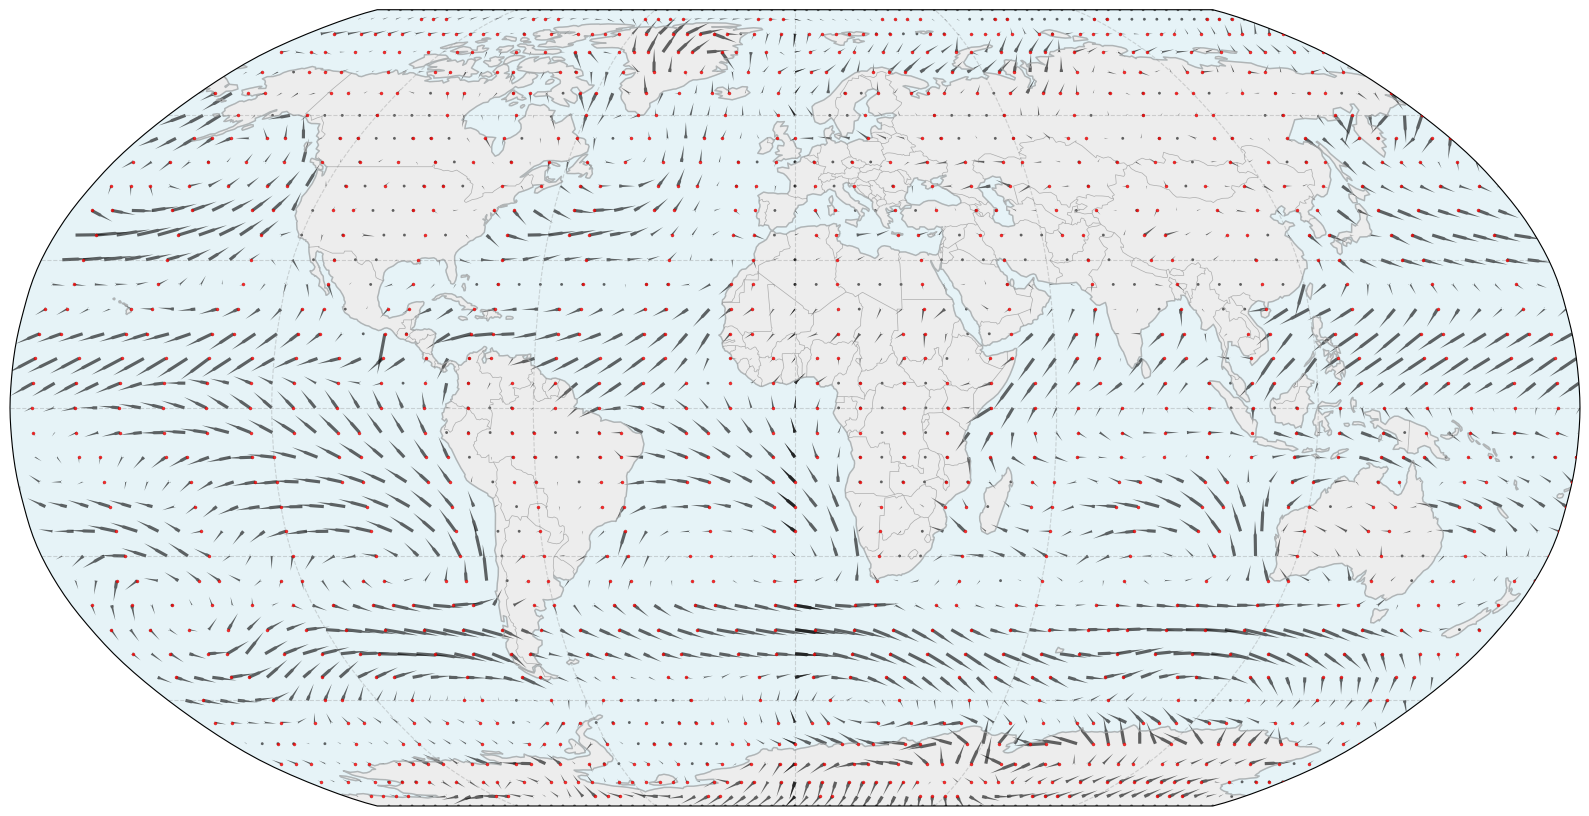

Earth projection plot created:
  Projection: Robinson
  Wind vectors: 2,701 arrows
  Training locations: 1,161 red dots
  Coverage: Global
  Style: Black arrows + red training dots

EARTH PROJECTION CREATED
✅ Global wind field: Black arrows showing direction & magnitude
✅ Training locations: Red dots showing Aeolus satellite measurements
✅ Robinson projection: Curved Earth view for global perspective
✅ No discontinuities: Longitude wrapping handled properly


In [13]:
# =============================================================================
# EARTH PROJECTION VISUALIZATION WITH TRAINING LOCATIONS
# =============================================================================

# Now that 'data' dictionary is available, create the Earth projection plot
print("Creating wind vectors on spherical Earth projection with training locations...")
plot_wind_velocity_earth_projection(skip_factor=1, figsize=(16, 10), projection='Robinson')

print("\n" + "="*60)
print("EARTH PROJECTION CREATED")
print("="*60)
print("✅ Global wind field: Black arrows showing direction & magnitude")
print("✅ Training locations: Red dots showing Aeolus satellite measurements")
print("✅ Robinson projection: Curved Earth view for global perspective")
print("✅ No discontinuities: Longitude wrapping handled properly")

In [14]:
# Precompute the step matrices for the kernel
# Create cache filename that reflects downsampling settings
cache_suffix = f"_ds{DOWNSAMPLE_FACTOR}" if USE_DOWNSAMPLING else "_fullres"
# cache_filename = f'../data/step_matrices/500hpa/step_matrices_walks_{WALKS_PER_NODE}_halt_{P_HALT}_maxlen_{MAX_WALK_LENGTH}_seed_{RANDOM_WALK_SEED}{cache_suffix}.pkl'

pp = GraphPreprocessor(
    adjacency_matrix=data['A'],
    walks_per_node=WALKS_PER_NODE,
    p_halt=P_HALT,
    max_walk_length=MAX_WALK_LENGTH,
    random_walk_seed=RANDOM_WALK_SEED,
    load_from_disk=LOAD_FROM_DISK,
    use_tqdm=True,
    # cache_filename=cache_filename,
    n_processes=None)

if not LOAD_FROM_DISK:
    step_matrices_torch = pp.preprocess_graph(save_to_disk=SAVE_TO_DISK)
else:
    step_matrices_torch = pp.step_matrices_torch

# Move step matrices to device
step_matrices_torch = [step_matrix.to(output_device) for step_matrix in step_matrices_torch]

Process walks:   0%|          | 0/134 [00:00<?, ?it/s]

Process walks: 100%|██████████| 134/134 [01:04<00:00,  2.08it/s]/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/graph_bo/notebooks/../../efficient_graph_gp_sparse/preprocessor/graph_preprocessor.py:135: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(


### Model Definition

In [15]:
# Model definition
class GraphGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood, step_matrices_torch):
        super().__init__(x_train, y_train, likelihood)
        self.x_train = x_train
        self.y_train = y_train
        self.mean_module = gpytorch.means.ZeroMean()
        self.step_matrices_torch = step_matrices_torch
        self.covar_module = SparseGRFKernel( 
            max_walk_length=MAX_WALK_LENGTH, 
            step_matrices_torch=self.step_matrices_torch
        )
        self.num_nodes = step_matrices_torch[0].shape[0]
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def predict(self, x_test, n_samples=64):
        """
        Batch pathwise conditioning sampling.
        
        f_test_posterior = f_test_prior + K_test_train @ v
        v = (K_train_train + noise_variance*I)^{-1} @ (y_train - (f_train_prior + eps))
        f_test_prior and f_train_prior are jointly sampled from N(0, K)
        eps ~ N(0, noise_variance*I)
        
        Args:
            x_test (torch.Tensor): Test input locations (shape: [n_test, 1])
            n_samples (int): Number of samples to generate from the posterior
        """    
        
        num_train = self.x_train.shape[0]
        train_indices = self.x_train.int().flatten()
        test_indices = x_test.int().flatten()
        
        # Get feature matrix and extract submatrices
        phi = self.covar_module._get_feature_matrix()
        phi_train = phi[train_indices, :]
        phi_test = phi[test_indices, :]
        
        # Precompute covariance matrices
        K_train_train = phi_train @ phi_train.T
        K_test_train = phi_test @ phi_train.T
        
        # Noise parameters
        noise_variance = self.likelihood.noise.item()
        noise_std = np.sqrt(noise_variance)
        A = K_train_train + noise_variance * IdentityLinearOperator(num_train, device=x_test.device)
        
        # Generate batch random samples
        eps1_batch = torch.randn(n_samples, self.num_nodes, device=x_test.device)
        eps2_batch = noise_std * torch.randn(n_samples, num_train, device=x_test.device)
        
        # Batch compute prior samples
        f_test_prior_batch = eps1_batch @ phi_test.T
        f_train_prior_batch = eps1_batch @ phi_train.T
        
        # Batch compute RHS vectors
        b_batch = self.y_train.unsqueeze(0) - (f_train_prior_batch + eps2_batch)
        
        # Batched CG solve:
        v_batch = linear_cg(
            matmul_closure=A._matmul,
            rhs=b_batch.T,
            tolerance=settings.cg_tolerance.value()
        )
        
        # Posterior samples at test inputs
        f_test_posterior_batch = f_test_prior_batch + (K_test_train @ v_batch).T

        return f_test_posterior_batch

# Initialize separate models for u and v components
likelihood_u = gpytorch.likelihoods.GaussianLikelihood()
likelihood_v = gpytorch.likelihoods.GaussianLikelihood()
likelihood_u = likelihood_u.to(output_device)
likelihood_v = likelihood_v.to(output_device)

model_u = GraphGPModel(data['X_train'], data['y_u_train'], likelihood_u, step_matrices_torch)
model_v = GraphGPModel(data['X_train'], data['y_v_train'], likelihood_v, step_matrices_torch)
model_u = model_u.to(output_device)
model_v = model_v.to(output_device)

In [16]:
# GPU setup confirmation
print(f"Model U device: {next(model_u.parameters()).device}")
print(f"Model V device: {next(model_v.parameters()).device}")
print(f"Data devices: X_train={data['X_train'].device}")
print(f"Step matrices device: {step_matrices_torch[0].device}")

Model U device: cuda:0
Model V device: cuda:0
Data devices: X_train=cuda:0
Step matrices device: cuda:0


### Training Loop

In [17]:
# Training function for component models
def train_component_model(model, likelihood, X_train, y_train, component_name, lr=0.01, max_iter=100):
    """Train individual component model"""
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    train_losses = []
    
    for i in range(max_iter):
        # Training step
        optimizer.zero_grad()
        train_output = model(X_train)
        train_loss = -mll(train_output, y_train)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        
        if i % PRINT_INTERVAL == 0:
            modulator = model.covar_module.modulator_vector.detach().cpu().numpy()
            print(f'{component_name} - Iter {i+1}: Train Loss={train_loss:.3f}, modulator={modulator}, noise={likelihood.noise.item():.4f}')
        
    return train_losses

# Train both component models
print("Training U-component model...")
train_losses_u = train_component_model(
    model_u, likelihood_u, data['X_train'], data['y_u_train'], 
    "U-component", lr=LEARNING_RATE, max_iter=MAX_ITERATIONS
)

print("\nTraining V-component model...")
train_losses_v = train_component_model(
    model_v, likelihood_v, data['X_train'], data['y_v_train'], 
    "V-component", lr=LEARNING_RATE, max_iter=MAX_ITERATIONS
)

Training U-component model...


/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/linear_operator/utils/sparse.py:66: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  res = cls(index_tensor, value_tensor, interp_size)
/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/linear_ope

U-component - Iter 1: Train Loss=5.217, modulator=[ 0.32669038  0.11880942  0.22446238  0.22033304 -1.1328564  -0.1963283
  2.1982014  -0.647997    0.45165724  0.2573509 ], noise=0.6883
U-component - Iter 31: Train Loss=3.538, modulator=[ 0.04834169 -0.17059997 -0.07152684 -0.0798045  -1.4349818  -0.5016534
  1.8822917  -0.9248906   0.13948226 -0.04355526], noise=0.5356
U-component - Iter 61: Train Loss=3.251, modulator=[ 2.4512924e-01 -2.8152848e-02  3.1676311e-02 -2.9554677e-03
 -1.3674265e+00 -4.6498415e-01  1.7581341e+00 -6.9554657e-01
  8.0746457e-02 -1.6305443e-03], noise=0.3913
U-component - Iter 91: Train Loss=2.985, modulator=[ 0.44094747  0.10744065  0.10557488  0.02496938 -1.3575752  -0.5095176
  1.484265   -0.46369368  0.01967177 -0.00478357], noise=0.2794
U-component - Iter 121: Train Loss=2.643, modulator=[ 6.5325582e-01  2.9742295e-01  2.2394004e-01  8.0126286e-02
 -1.3298390e+00 -5.7412076e-01  1.1092284e+00 -2.3597245e-01
  1.0604339e-03 -2.9676899e-03], noise=0.1948
U

### Inference

In [18]:
# Predict on all nodes for visualization
print("\n=== GENERATING FULL GRAPH PREDICTIONS ===")
with torch.no_grad():
    X_all = torch.arange(len(data['y']), dtype=torch.float32, device=output_device).unsqueeze(1)
    
    # Predict U and V components separately
    print("Predicting U-component...")
    u_samples = model_u.predict(X_all, n_samples=PATHWISE_SAMPLES)
    u_mean = u_samples.mean(dim=0)
    u_std = u_samples.std(dim=0)
    
    print("Predicting V-component...")
    v_samples = model_v.predict(X_all, n_samples=PATHWISE_SAMPLES)
    v_mean = v_samples.mean(dim=0)
    v_std = v_samples.std(dim=0)

print(f"Generated predictions for all {len(data['y'])} nodes")
print(f"U-component range: [{u_mean.min():.3f}, {u_mean.max():.3f}]")
print(f"V-component range: [{v_mean.min():.3f}, {v_mean.max():.3f}]")
print(f"All predictions in normalized scale (mean=0, std=1)")


=== GENERATING FULL GRAPH PREDICTIONS ===
Predicting U-component...
Predicting V-component...
Generated predictions for all 2664 nodes
U-component range: [-2.510, 3.148]
V-component range: [-3.501, 3.174]
All predictions in normalized scale (mean=0, std=1)


CREATING FOUR ROBINSON PROJECTION VISUALIZATIONS

1. Ground Truth Wind Vectors
Creating ground truth vector field using Robinson projection


/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/cartopy/crs.py:547: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


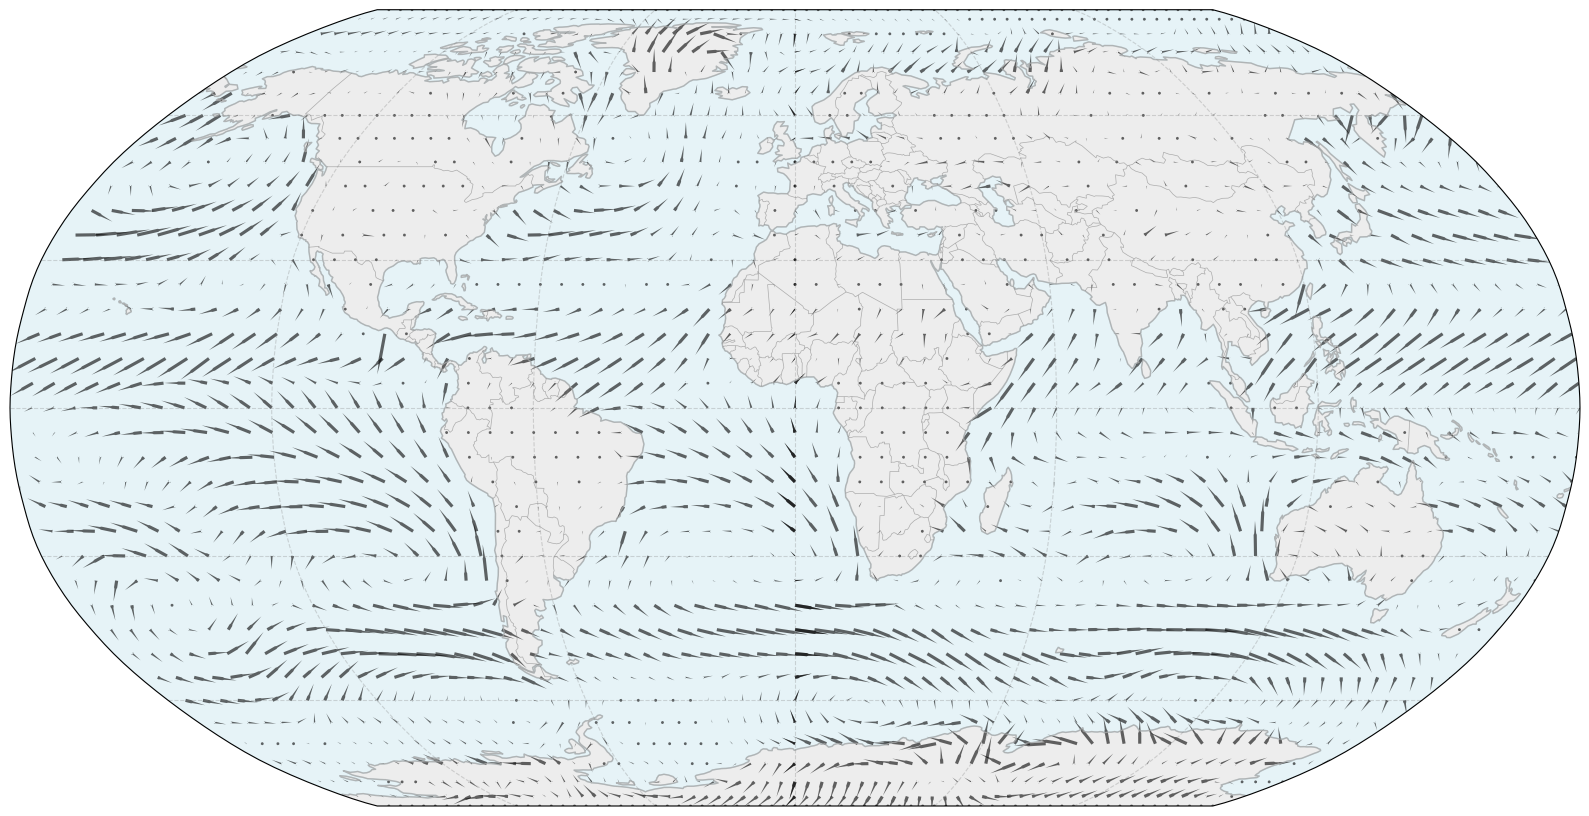


2. Predicted Mean Wind Vectors
Creating predicted mean vector field using Robinson projection


/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


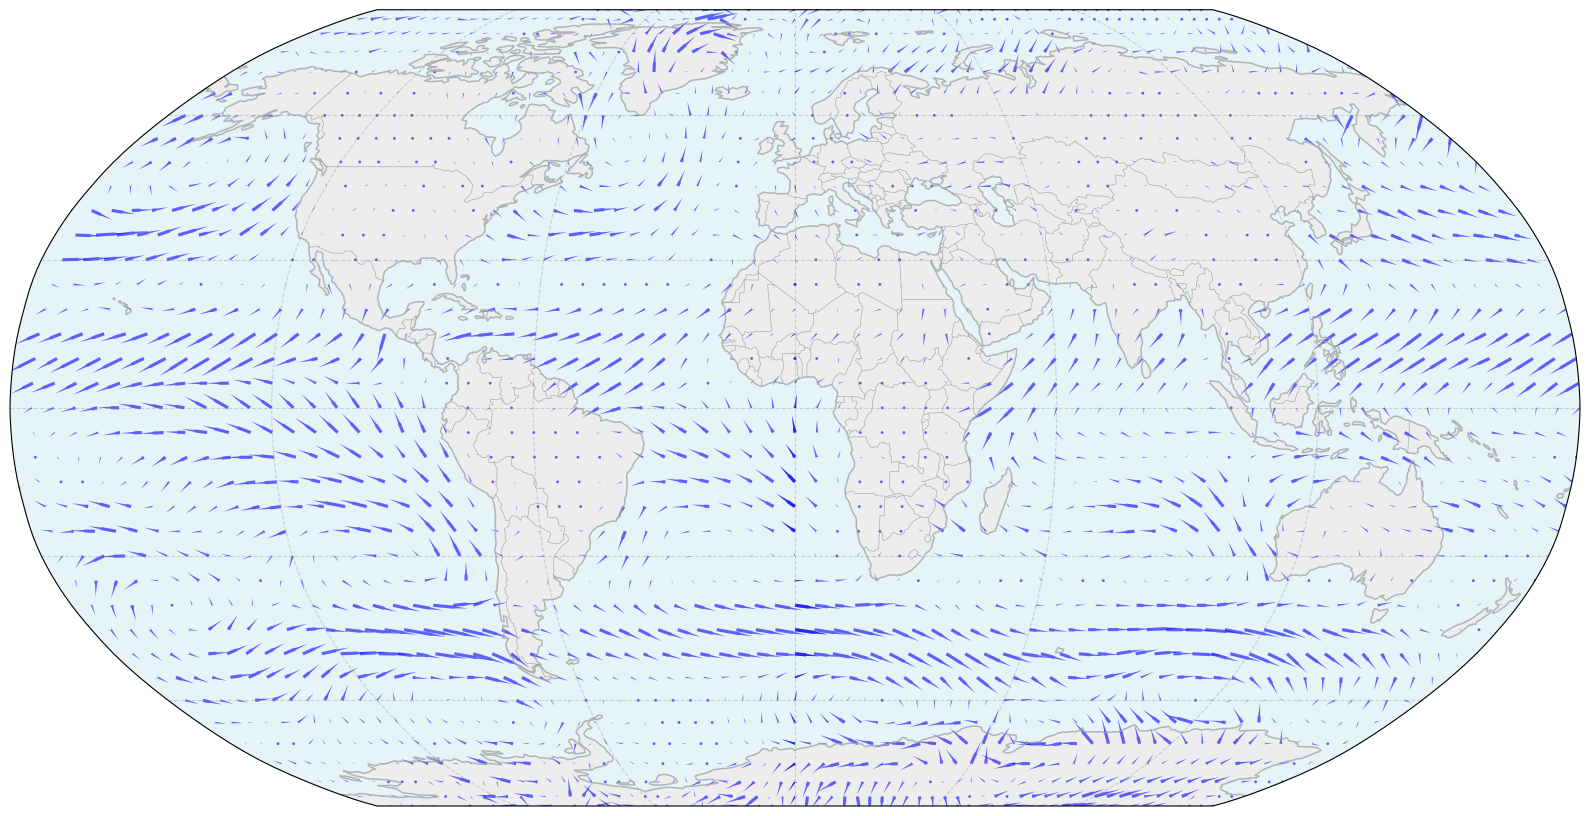


3. Prediction Uncertainty Heatmap
Creating uncertainty heatmap using Robinson projection


/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


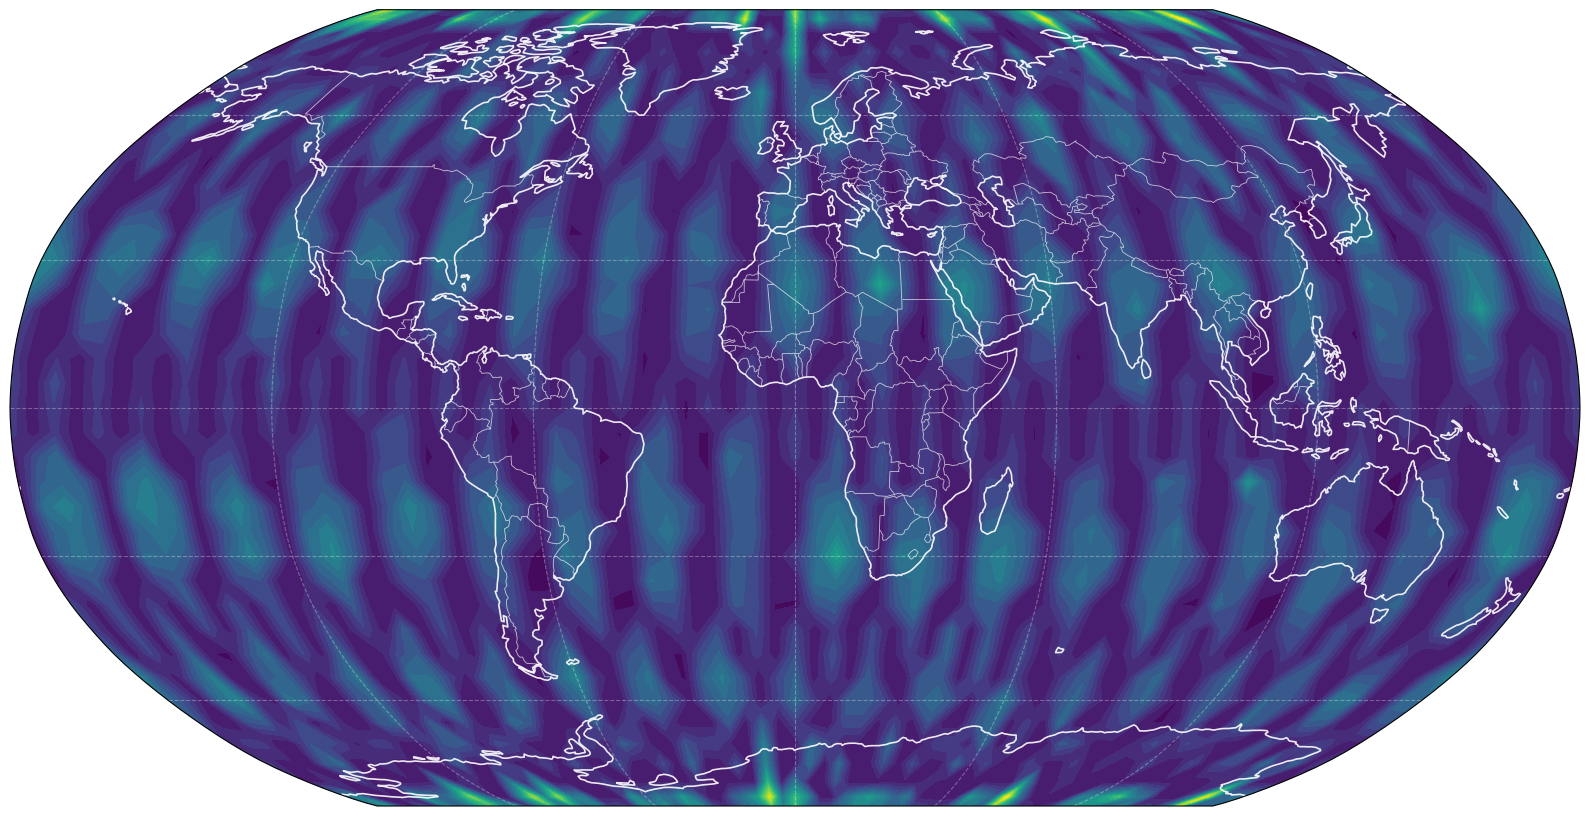

Uncertainty statistics: [0.800, 6.818] m/s, mean: 1.744 m/s

4. Absolute Error Heatmap
Creating error magnitude heatmap using Robinson projection


/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


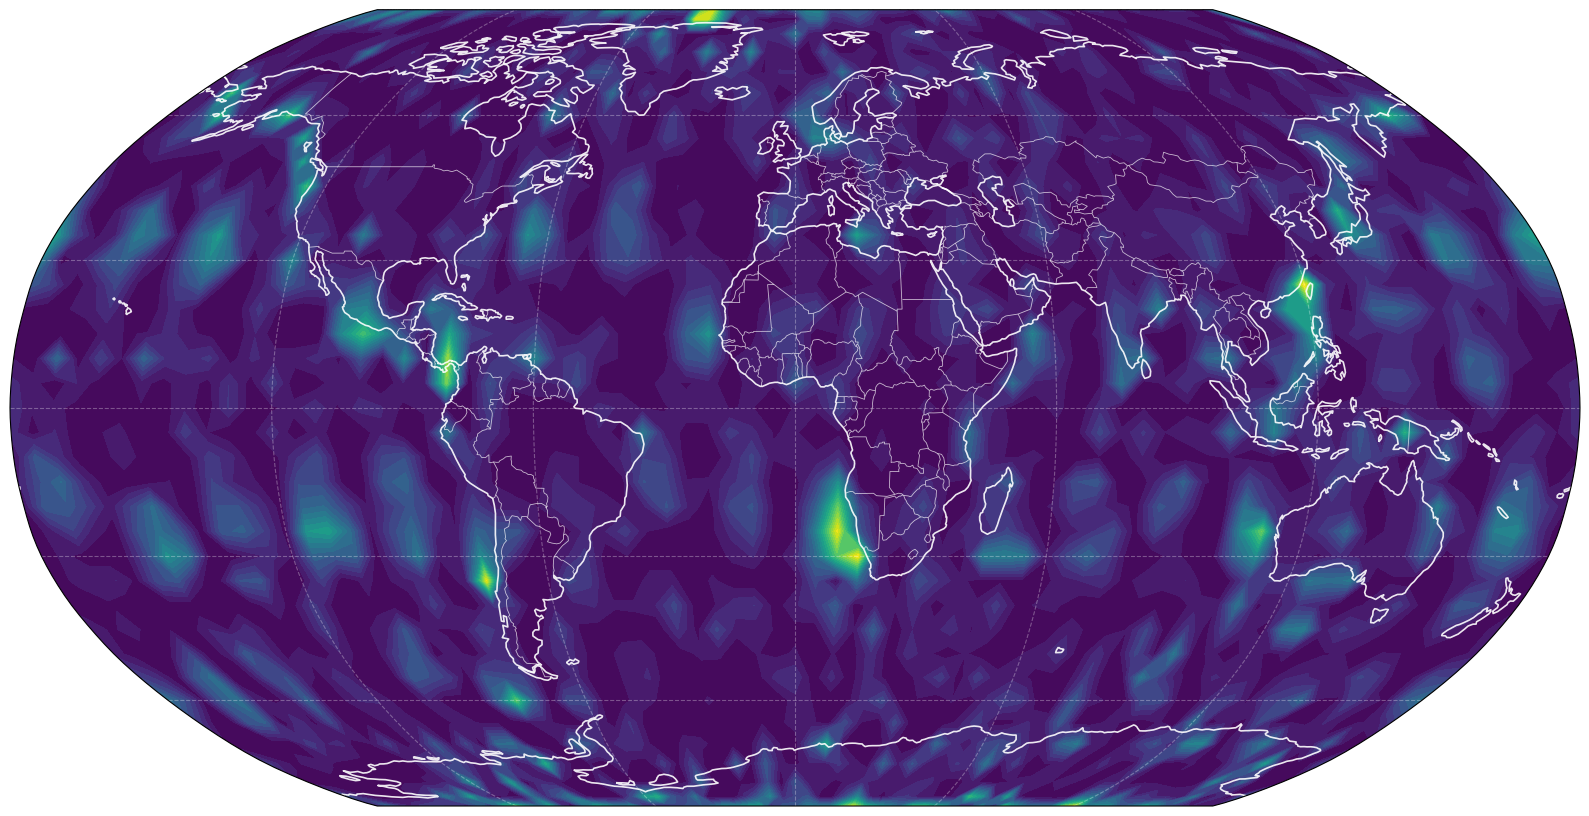

Error statistics:
  Range: [0.000, 8.445] m/s
  Mean absolute error: 0.961 m/s
  RMSE: 1.512 m/s
  Error distribution:
    < 1.0 m/s: 68.8% of nodes
    < 2.0 m/s: 85.5% of nodes
    < 5.0 m/s: 98.6% of nodes

ALL FOUR ROBINSON PROJECTIONS COMPLETED


In [ ]:
# =============================================================================
# FOUR SEPARATE ROBINSON PROJECTION PLOTS
# =============================================================================

def plot_ground_truth_vectors(skip_factor=3, figsize=(16, 10), projection='Robinson'):
    """Ground truth wind vectors on Robinson projection"""
    try:
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        print(f"Creating ground truth vector field using {projection} projection")
    except ImportError:
        print("Cartopy not available, cannot create Earth projection")
        return
    
    # Handle longitude wrapping
    lon_extended = np.append(lon_processed, lon_processed[0] + 360)
    u_extended = np.concatenate([u_500_processed, u_500_processed[:, 0:1]], axis=1)
    v_extended = np.concatenate([v_500_processed, v_500_processed[:, 0:1]], axis=1)
    
    # Create coordinate grids
    lon_2d_ext, lat_2d_ext = np.meshgrid(lon_extended, lat_processed)
    
    # Apply skip factor for arrows
    lon_skip = lon_2d_ext[::skip_factor, ::skip_factor]
    lat_skip = lat_2d_ext[::skip_factor, ::skip_factor]
    u_skip = u_extended[::skip_factor, ::skip_factor]
    v_skip = v_extended[::skip_factor, ::skip_factor]
    
    # Create figure
    proj = ccrs.Robinson(central_longitude=0)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=proj)
    
    # Add Earth features
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0, color='darkgray', alpha=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, color='gray', alpha=0.6)
    ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.4)
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
    
    # Create quiver plot - ground truth vectors
    quiver = ax.quiver(
        lon_skip, lat_skip, u_skip, v_skip,
        angles='xy', scale_units='width', scale=500,
        width=0.002, headwidth=0.6, headlength=4,
        color='black', alpha=0.6,
        transform=ccrs.PlateCarree()
    )
    
    ax.set_global()
    gl = ax.gridlines(draw_labels=False, alpha=0.3, linestyle='--', color='gray')
    plt.tight_layout()
    plt.show()

def plot_predicted_mean_vectors(u_pred, v_pred, skip_factor=3, figsize=(16, 10), projection='Robinson'):
    """Predicted mean wind vectors on Robinson projection"""
    try:
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        print(f"Creating predicted mean vector field using {projection} projection")
    except ImportError:
        print("Cartopy not available, cannot create Earth projection")
        return
    
    # Convert predictions to numpy and denormalize
    u_pred_np = u_pred.cpu().numpy()
    v_pred_np = v_pred.cpu().numpy()
    u_denorm = u_pred_np * data['y_u_std'] + data['y_u_mean']
    v_denorm = v_pred_np * data['y_v_std'] + data['y_v_mean']
    
    # Reshape to 2D grid
    n_lat, n_lon = len(lat_processed), len(lon_processed)
    u_2d = u_denorm.reshape((n_lat, n_lon))
    v_2d = v_denorm.reshape((n_lat, n_lon))
    
    # Handle longitude wrapping
    lon_extended = np.append(lon_processed, lon_processed[0] + 360)
    u_extended = np.concatenate([u_2d, u_2d[:, 0:1]], axis=1)
    v_extended = np.concatenate([v_2d, v_2d[:, 0:1]], axis=1)
    
    # Create coordinate grids
    lon_2d_ext, lat_2d_ext = np.meshgrid(lon_extended, lat_processed)
    
    # Apply skip factor for arrows
    lon_skip = lon_2d_ext[::skip_factor, ::skip_factor]
    lat_skip = lat_2d_ext[::skip_factor, ::skip_factor]
    u_skip = u_extended[::skip_factor, ::skip_factor]
    v_skip = v_extended[::skip_factor, ::skip_factor]
    
    # Create figure
    proj = ccrs.Robinson(central_longitude=0)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=proj)
    
    # Add Earth features
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0, color='darkgray', alpha=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, color='gray', alpha=0.6)
    ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.4)
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
    
    # Create quiver plot - predicted mean vectors
    quiver = ax.quiver(
        lon_skip, lat_skip, u_skip, v_skip,
        angles='xy', scale_units='width', scale=500,
        width=0.002, headwidth=0.6, headlength=4,
        color='blue', alpha=0.6,
        transform=ccrs.PlateCarree()
    )
    
    ax.set_global()
    gl = ax.gridlines(draw_labels=False, alpha=0.3, linestyle='--', color='gray')
    plt.tight_layout()
    plt.show()

def plot_uncertainty_heatmap(u_std, v_std, figsize=(16, 10), projection='Robinson'):
    """Uncertainty heatmap on Robinson projection"""
    try:
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        print(f"Creating uncertainty heatmap using {projection} projection")
    except ImportError:
        print("Cartopy not available, cannot create Earth projection")
        return
    
    # Convert uncertainties to numpy and denormalize
    u_std_np = u_std.cpu().numpy()
    v_std_np = v_std.cpu().numpy()
    u_std_denorm = u_std_np * data['y_u_std']
    v_std_denorm = v_std_np * data['y_v_std']
    
    # Calculate combined uncertainty magnitude
    uncertainty_magnitude = np.sqrt(u_std_denorm**2 + v_std_denorm**2)
    
    # Reshape to 2D grid
    n_lat, n_lon = len(lat_processed), len(lon_processed)
    uncertainty_2d = uncertainty_magnitude.reshape((n_lat, n_lon))
    
    # Handle longitude wrapping
    lon_extended = np.append(lon_processed, lon_processed[0] + 360)
    uncertainty_extended = np.concatenate([uncertainty_2d, uncertainty_2d[:, 0:1]], axis=1)
    
    # Create coordinate grids
    lon_2d_ext, lat_2d_ext = np.meshgrid(lon_extended, lat_processed)
    
    # Create figure
    proj = ccrs.Robinson(central_longitude=0)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=proj)
    
    # Create uncertainty heatmap
    contour_levels = 20
    uncertainty_contour = ax.contourf(
        lon_2d_ext, lat_2d_ext, uncertainty_extended,
        levels=contour_levels,
        cmap='viridis',
        transform=ccrs.PlateCarree(),
        extend='max'
    )
    
    # Add Earth features with white borders for contrast
    ax.add_feature(cfeature.COASTLINE, linewidth=1.2, color='white', alpha=0.9)
    ax.add_feature(cfeature.BORDERS, linewidth=0.6, color='white', alpha=0.7)
    
    ax.set_global()
    gl = ax.gridlines(draw_labels=False, alpha=0.3, linestyle='--', color='white')
    
    # Add colorbar at bottom
    cbar = plt.colorbar(uncertainty_contour, ax=ax, orientation='horizontal', 
                       shrink=0.8, pad=0.05, aspect=40)
    cbar.set_label('Uncertainty (m/s)', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    unc_min, unc_max = uncertainty_magnitude.min(), uncertainty_magnitude.max()
    unc_mean = uncertainty_magnitude.mean()
    print(f"Uncertainty statistics: [{unc_min:.3f}, {unc_max:.3f}] m/s, mean: {unc_mean:.3f} m/s")

def plot_error_magnitude_heatmap(u_pred, v_pred, figsize=(16, 10), projection='Robinson'):
    """Error magnitude heatmap on Robinson projection"""
    try:
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        print(f"Creating error magnitude heatmap using {projection} projection")
    except ImportError:
        print("Cartopy not available, cannot create Earth projection")
        return
    
    # Convert predictions to numpy and denormalize
    u_pred_np = u_pred.cpu().numpy()
    v_pred_np = v_pred.cpu().numpy()
    u_pred_denorm = u_pred_np * data['y_u_std'] + data['y_u_mean']
    v_pred_denorm = v_pred_np * data['y_v_std'] + data['y_v_mean']
    
    # Get ground truth (already denormalized)
    u_true_denorm = data['u_component'].cpu().numpy()
    v_true_denorm = data['v_component'].cpu().numpy()
    
    # Calculate predicted and true wind speed magnitudes
    wind_speed_pred = np.sqrt(u_pred_denorm**2 + v_pred_denorm**2)
    wind_speed_true = np.sqrt(u_true_denorm**2 + v_true_denorm**2)
    
    # Calculate absolute error in wind speed magnitude
    error_magnitude = np.abs(wind_speed_pred - wind_speed_true)
    
    # Reshape to 2D grid
    n_lat, n_lon = len(lat_processed), len(lon_processed)
    error_2d = error_magnitude.reshape((n_lat, n_lon))
    
    # Handle longitude wrapping
    lon_extended = np.append(lon_processed, lon_processed[0] + 360)
    error_extended = np.concatenate([error_2d, error_2d[:, 0:1]], axis=1)
    
    # Create coordinate grids
    lon_2d_ext, lat_2d_ext = np.meshgrid(lon_extended, lat_processed)
    
    # Create figure
    proj = ccrs.Robinson(central_longitude=0)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=proj)
    
    # Create error magnitude heatmap
    contour_levels = 25
    error_contour = ax.contourf(
        lon_2d_ext, lat_2d_ext, error_extended,
        levels=contour_levels,
        cmap='viridis',  # Changed from plasma to viridis
        transform=ccrs.PlateCarree(),
        extend='max'
    )
    
    # Add Earth features with white borders for contrast
    ax.add_feature(cfeature.COASTLINE, linewidth=1.2, color='white', alpha=0.9)
    ax.add_feature(cfeature.BORDERS, linewidth=0.6, color='white', alpha=0.7)
    
    ax.set_global()
    gl = ax.gridlines(draw_labels=False, alpha=0.3, linestyle='--', color='white')
    
    # Add colorbar at bottom
    cbar = plt.colorbar(error_contour, ax=ax, orientation='horizontal', 
                       shrink=0.8, pad=0.05, aspect=40)
    cbar.set_label('Absolute Error (m/s)', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print error statistics
    error_min, error_max = error_magnitude.min(), error_magnitude.max()
    error_mean = error_magnitude.mean()
    error_std = error_magnitude.std()
    error_rmse = np.sqrt(np.mean(error_magnitude**2))
    
    print(f"Error statistics:")
    print(f"  Range: [{error_min:.3f}, {error_max:.3f}] m/s")
    print(f"  Mean absolute error: {error_mean:.3f} m/s")
    print(f"  RMSE: {error_rmse:.3f} m/s")
    
    # Calculate percentage of nodes with different error thresholds
    low_error = np.sum(error_magnitude < 1.0) / len(error_magnitude) * 100
    med_error = np.sum(error_magnitude < 2.0) / len(error_magnitude) * 100
    high_error = np.sum(error_magnitude < 5.0) / len(error_magnitude) * 100
    
    print(f"  Error distribution:")
    print(f"    < 1.0 m/s: {low_error:.1f}% of nodes")
    print(f"    < 2.0 m/s: {med_error:.1f}% of nodes") 
    print(f"    < 5.0 m/s: {high_error:.1f}% of nodes")

# Create all four Robinson projection plots
print("="*60)
print("CREATING FOUR ROBINSON PROJECTION VISUALIZATIONS")
print("="*60)

print("\n1. Ground Truth Wind Vectors")
plot_ground_truth_vectors(skip_factor=1, figsize=(16, 10))

print("\n2. Predicted Mean Wind Vectors")
plot_predicted_mean_vectors(u_mean, v_mean, skip_factor=1, figsize=(16, 10))

print("\n3. Prediction Uncertainty Heatmap")
plot_uncertainty_heatmap(u_std, v_std, figsize=(16, 10))

print("\n4. Absolute Error Heatmap")
plot_error_magnitude_heatmap(u_mean, v_mean, figsize=(16, 10))

print("\n" + "="*60)
print("ALL FOUR ROBINSON PROJECTIONS COMPLETED")